In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from Causal_inference import granger_causality,add_causality_dataset, generate_synthetic
from time import time
import pmdarima as pm
from tqdm import tqdm
from statsmodels.tsa.arima_model import ARMA
from TimeSeries import TimeSeries
from copy import deepcopy

In [3]:
def load_dataset(path):
    path = path
    TRAIN, train_labels = TimeSeries.load(path+'_TRAIN', "UCR")
    TEST, test_labels = TimeSeries.load(path+'_TEST', "UCR")

    return TRAIN, train_labels, TEST, test_labels

def plot(x):
    l = np.arange(x.shape[0])
    plt.plot(l, x, c='blue')
    plt.show()


def adf_test(x, pval = 0.05):
    """
    Test if the time series is stationary
    :param x: time series
    :return:
    """
    dftest = adfuller(x, autolag='AIC')
    if dftest[1] < pval:
        return True
    else:
        return False
    
def difference(x):
    m = x.shape[0]
    diff = [x[0]]
    for i in range(1,m):
        val = x[i] - x[i-1]
        diff.append(val)
    diff = np.array(diff)
    return diff

def make_stationary(x, plot = False):
    """
    Take difference until statinonary
    :param x: time series
    :return:
    """
    for it in range(10):
        diff = []
        if adf_test(x):
            return np.array(x)
        for i in range(1, len(x)):
            val = x[i] - x[i - 1]
            diff.append(val)
        x = diff

        if it == 9:
            print('Cannot be made stationary')

        if plot:
            l = np.arange(len(diff))
            plt.plot(l, x, c='blue')
            plt.show()
    return np.array(x)


def preprocess_dataset(TS):
    """
    Make each time series stationary
    :param TS: 
    :return: 
    """
    minlength = float('inf')
    newTS = [None for i in range(TS.shape[0])]
    for i in range(TS.shape[0]):
        newTS[i] = make_stationary(TS[i])
        minlength = min(minlength, len(newTS[i]))
    for i in range(TS.shape[0]):
        m = len(newTS[i])
        newTS[i] = newTS[i][(m-minlength):]
    return np.array(newTS)

def add_causality(x, y, lag):
    m = y.shape[0]
    for i in range(m-lag):
        y[i + lag] += x[i]
        
def random_walk(drift = 0, m = 128, sd = 1):
    ls = [None] * m
    ls[0] = np.random.normal(0,1)
    for i in range(1, m):
        ls[i] = ls[i-1] + drift + np.random.normal(0,sd)
    return np.array(ls)

def add_rwalk_to_db(ts, sd = 0.1):
    newts = deepcopy(ts)
    for i in range(newts.shape[0]):
        newts[i] += random_walk(m = newts.shape[1], sd = sd)
    return newts

def generate_with_rwalk(sd = 0.1):
    noisydata = np.load('ecgarimanoisy200.npy')
    plot(noisydata[1])
    for i in range(1,200, 2):
        walk = random_walk(m = 96, sd= sd)
        noisydata[i] += walk
    plot(noisydata[1])
    return noisydata
    
def add_noise(TS, sd):
    n,m  = TS.shape
    newTS = deepcopy(TS)
    for i in range(n):
        newTS[i] += np.random.normal(0, sd, m)
    return newTS

In [4]:
ts, train_labels, TEST, test_labels = load_dataset('UCR2018/Fish/Fish')

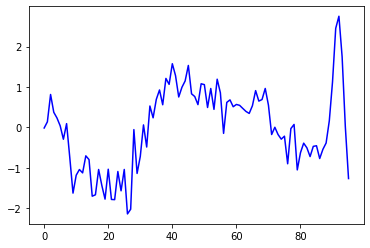

In [5]:
noisydata = np.load('ecgarimanoisy200.npy')
plot(noisydata[3])

for i in range(1,200, 2):
    noisydata[i] += random_walk(m = 96, sd= 0.1)

In [6]:
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/cmiknn.py:15: UserWarning: cannot import name 'tigramite_cython_code' from 'tigramite' (/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/__init__.py)
  warnings.warn(str(e))


In [7]:
f = np.array([1,2,3])
g = np.array([4,5,6])

f = np.vstack((f, g))
print(f)

[[1 2 3]
 [4 5 6]]


(<Figure size 432x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb469d4eb0>,
       dtype=object))

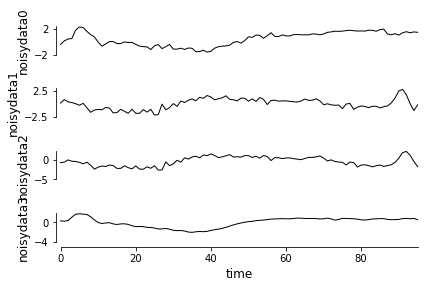

In [8]:
sample_set_data = np.empty(shape=[96, 1])
var_names = []
for i in range(5):
    n = noisydata[i].reshape(len(noisydata[i]), 1)
    name = f"noisydata{i}"
    var_names.append(name)
    if i ==1:
        sample_set_data = n
    else:
        sample_set_data = np.hstack((sample_set_data, n))
# T = len(noisydata[3])
# data, true_parents_neighbors = pp.var_process(sample_set_data, T=T)

# n = noisydata[3].reshape(len(noisydata[3]), 1)
df = pp.DataFrame(sample_set_data, datatime = np.arange(len(noisydata[3])),var_names=var_names)
tp.plot_timeseries(df)


1: PCMCI

initialize pcmi object

In [9]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)

Unconditional Dependencies, Lagged Correlations

Choosing the tau_max


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


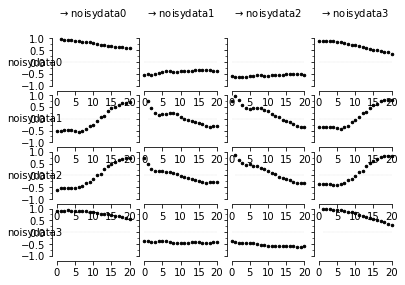

In [10]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [11]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable noisydata0 has 5 link(s):
    [pc_alpha = 0.5]
        (noisydata0 -1): max_pval = 0.00000, min_val =  0.516
        (noisydata0 -3): max_pval = 0.00861, min_val =  0.296
        (noisydata3 -1): max_pval = 0.01339, min_val =  0.288
        (noisydata1 -2): max_pval = 0.28254, min_val =  0.127
        (noisydata3 -2): max_pval = 0.40191, min_val = -0.100

    Variable noisydata1 has 4 link(s):
    [pc_alpha = 0.5]
        (noisydata1 -1): max_pval = 0.00000, min_val =  0.584
        (noisydata3 -8): max_pval = 0.28012, min_val = -0.125
        (noisydata3 -5): max_pval = 0.41838, min_val = -0.092
        (noisydata0 -7): max_pval = 0.44381, min_val = -0.088

    Variable noisydata2 has 9 link(s):
    [pc_alpha = 0.5]
        (n

p-values

correlations

In [12]:

print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.12  0.    0.018 0.073 0.226 0.298 0.62 ]
  [0.041 0.539 0.326 0.037 0.66  0.724 0.377 0.533 0.117]
  [0.877 0.242 0.961 0.304 0.864 0.116 0.891 0.2   0.004]
  [0.75  0.752 0.565 0.512 0.559 0.521 0.635 0.262 0.352]]

 [[0.041 0.433 0.092 0.698 0.929 0.724 0.961 0.554 0.47 ]
  [1.    0.    0.719 0.108 0.026 0.089 0.259 0.918 0.26 ]
  [0.033 0.    0.    0.009 0.007 0.243 0.084 0.541 0.691]
  [0.757 0.653 0.281 0.979 0.016 0.653 0.506 0.279 0.538]]

 [[0.877 0.28  0.8   0.418 0.985 0.701 0.925 0.43  0.96 ]
  [0.033 0.128 0.305 0.96  0.292 0.446 0.61  0.696 0.821]
  [1.    0.    0.    0.001 0.003 0.094 0.803 0.733 0.961]
  [0.075 0.611 0.485 0.57  0.    0.    0.523 0.002 0.045]]

 [[0.75  0.034 0.3   0.629 0.423 0.125 0.683 0.441 0.756]
  [0.757 0.213 0.103 0.654 0.202 0.903 0.263 0.25  0.311]
  [0.075 0.128 0.261 0.305 0.881 0.006 0.556 0.908 0.224]
  [1.    0.    0.    0.    0.007 0.798 0.205 0.889 0.123]]]
MCI partial correlations
[[[ 0.    0.64 -0.19  0.47 -0.

In [13]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable noisydata0 has 2 link(s):
        (noisydata0 -1): pval = 0.00000 | qval = 0.00000 | val =  0.638
        (noisydata0 -3): pval = 0.00004 | qval = 0.00056 | val =  0.465

    Variable noisydata1 has 1 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00002 | val =  0.536

    Variable noisydata2 has 5 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.988
        (noisydata2 -1): pval = 0.00000 | qval = 0.00000 | val =  0.737
        (noisydata1 -2): pval = 0.00000 | qval = 0.00000 | val = -0.603
        (noisydata2 -2): pval = 0.00004 | qval = 0.00055 | val =  0.487
        (noisydata2 -3): pval = 0.00098 | qval = 0.00962 | val =  0.402

    Variable noisydata3 has 5 link(s):
        (noisydata3 -1): pval = 0.00000 | qval = 0.00000 | val =  0.817
        (noisydata3 -2): pval = 0.00000 | qval = 0.00000 | val = -0.584
        (noisydata3 -3): pval = 0.00000 | qval = 0.00006 | val =  0.536
        (

links occuring at multiple lags between two variables?

In [14]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

print(link_matrix)

[[[False  True False  True False False False False False]
  [False False False False False False False False False]
  [False False False False False False False False False]
  [False False False False False False False False False]]

 [[False False False False False False False False False]
  [False  True False False False False False False False]
  [False  True  True False False False False False False]
  [False False False False False False False False False]]

 [[False False False False False False False False False]
  [False False False False False False False False False]
  [False  True  True  True False False False False False]
  [False False False False  True  True False False False]]

 [[False False False False False False False False False]
  [False False False False False False False False False]
  [False False False False False False False False False]
  [False  True  True  True False False False False False]]]


In [15]:
# tp.plot_graph(
#     val_matrix=results['val_matrix'],
#     link_matrix=link_matrix,
#     var_names=var_names,
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     ); plt.show()

2: PCMCI-plus

In [16]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


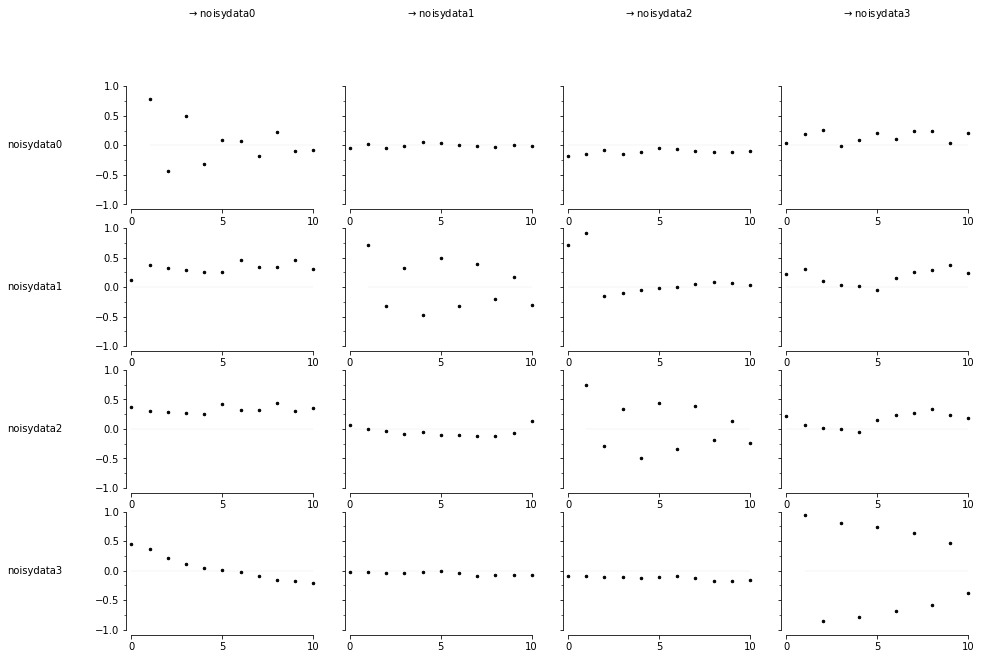

In [17]:
correlations = pcmci.run_bivci(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

In [18]:
tau_max = 3
pc_alpha = 0.01
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable noisydata0

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (noisydata0 -1) --> noisydata0 (1/12):
    Subset 0: () gives pval = 0.00000 / val =  0.962
    No conditions of dimension 0 left.

    Link (noisydata0 -2) --> noisydata0 (2/12):
    Subset 0: () gives pval = 0.00000 / val =  0.919
    No conditions of dimension 0 left.

    Link (noisydata0 -3) --> noisydata0 (3/12):
    Subset 0: () gives pval = 0.00000 / val =  0.884
    No conditions of dimension 0 left.

    Link (noisydata1 -1) --> noisydata0 (4/12):
    Subset 0: () gives pval = 0.45880 / val =  0.079
    Non-significance detected.

    Link (noisydata1 -2) --> noisydata0 (5/12):
    Subset 0: () gives pval = 0.09609 / val =  0.177
    Non-significance detected.


In [19]:
print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '-->' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '-->' '' '']
  ['' '-->' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '' '' '']
  ['' '-->' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '-->' '-->' '-->']]]
Adjacency MCI partial correlations
[[[ 0.    0.73 -0.09  0.12]
  [-0.13 -0.03 -0.1  -0.14]
  [-0.12 -0.1  -0.14 -0.2 ]
  [ 0.21  0.09 -0.07 -0.19]]

 [[-0.13  0.08  0.18  0.22]
  [ 0.    0.61  0.05  0.14]
  [ 0.15  0.99  0.2   0.27]
  [ 0.13  0.09  0.17  0.23]]

 [[-0.12  0.07  0.12  0.16]
  [ 0.15  0.1   0.15  0.02]
  [ 0.    0.91  0.2   0.25]
  [-0.03  0.08  0.14  0.18]]

 [[ 0.21  0.24 -0.   -0.08]
  [ 0.13 -0.07 -0.13 -0.19]
  [-0.03 -0.08 -0.16 -0.22]
  [ 0.    0.9  -0.72  0.6 ]]]
Adjacency p-values
[[[1.    0.    0.401 0.283]
  [0.241 0.756 0.361 0.203]
  [0.277 0.366 0.179 0.054]
  [0.051 0.414 0.543 0.08 ]]

 [[0.241 0.459 0.096 0.036]
  [1.    0.    0.633 0.195]
  [0.165 0.    0.059 0.011]
 

In [20]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh',
                                                  exclude_contemporaneous=False)

In [25]:
# link_matrix = results['graph']
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
print(type(link_matrix[0][0][0]))
print(link_matrix)

<class 'numpy.bool_'>
[[[False  True False False]
  [False False False False]
  [False False False False]
  [False False False False]]

 [[False False False False]
  [False  True False False]
  [False  True False False]
  [False False False False]]

 [[False False False False]
  [False False False False]
  [False  True False False]
  [False False False False]]

 [[False False False False]
  [False False False False]
  [False False False False]
  [False  True  True  True]]]


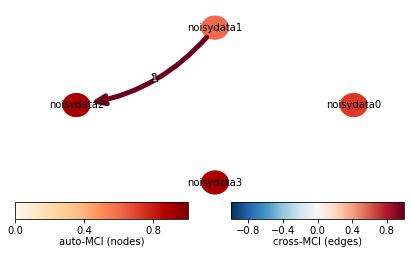

In [22]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

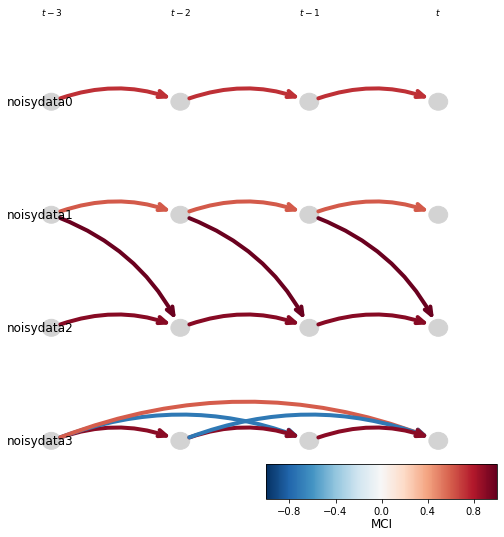

In [23]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()